In [1]:
#Import pyspark
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("NYC Parking") \
    .getOrCreate()

In [2]:
#Create dataframe by calling read() method on SparkSession/spark object
nyc_park = spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load('/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv')

nyc_park.show()

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08 00:00:00|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23 00:00:00|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|         

In [3]:
nyc_park.printSchema()

# printSchema returns schema in tree format

root
 |-- Summons Number: long (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: timestamp (nullable = true)
 |-- Violation Code: integer (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: integer (nullable = true)
 |-- Issuer Precinct: integer (nullable = true)
 |-- Violation Time: string (nullable = true)



In [4]:
nyc_park.schema
#Returns the schema of this DataFrame as a pyspark.sql.types.StructType.

StructType(List(StructField(Summons Number,LongType,true),StructField(Plate ID,StringType,true),StructField(Registration State,StringType,true),StructField(Issue Date,TimestampType,true),StructField(Violation Code,IntegerType,true),StructField(Vehicle Body Type,StringType,true),StructField(Vehicle Make,StringType,true),StructField(Violation Precinct,IntegerType,true),StructField(Issuer Precinct,IntegerType,true),StructField(Violation Time,StringType,true)))

In [5]:
#Total number of rows present
nyc_park.count()

10803028

In [6]:
nyc_park.columns

['Summons Number',
 'Plate ID',
 'Registration State',
 'Issue Date',
 'Violation Code',
 'Vehicle Body Type',
 'Vehicle Make',
 'Violation Precinct',
 'Issuer Precinct',
 'Violation Time']

In [7]:
nyc_park.distinct().count()

10803028

In [8]:
nyc_park.createOrReplaceTempView("nycparktable")
spark.sql("select * from nycparktable")

DataFrame[Summons Number: bigint, Plate ID: string, Registration State: string, Issue Date: timestamp, Violation Code: int, Vehicle Body Type: string, Vehicle Make: string, Violation Precinct: int, Issuer Precinct: int, Violation Time: string]

In [9]:
from pyspark.sql.functions import count
nyc_park.select(count("Summons Number")).show()

+---------------------+
|count(Summons Number)|
+---------------------+
|             10803028|
+---------------------+



In [10]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Plate ID")).show()

+------------------------+
|count(DISTINCT Plate ID)|
+------------------------+
|                 3059046|
+------------------------+



In [11]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Registration State")).show()

+----------------------------------+
|count(DISTINCT Registration State)|
+----------------------------------+
|                                67|
+----------------------------------+



In [12]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Violation Code")).show()

+------------------------------+
|count(DISTINCT Violation Code)|
+------------------------------+
|                           100|
+------------------------------+



In [13]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Violation Precinct")).show()

+----------------------------------+
|count(DISTINCT Violation Precinct)|
+----------------------------------+
|                               213|
+----------------------------------+



In [14]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Issuer Precinct")).show()

+-------------------------------+
|count(DISTINCT Issuer Precinct)|
+-------------------------------+
|                            655|
+-------------------------------+



In [15]:
# Total number of tickets for each year
spark.sql("select year(`Issue Date`) as Year, count(`Summons Number`) as Number_of_tickets\
          from nycparktable group by year order by year").show()


+----+-----------------+
|Year|Number_of_tickets|
+----+-----------------+
|1972|                2|
|1973|                2|
|1974|                1|
|1976|                1|
|1977|                1|
|1984|                1|
|1985|                1|
|1990|                2|
|1991|                3|
|1994|                1|
|1996|                1|
|1997|                1|
|2000|              185|
|2001|                2|
|2002|                1|
|2003|                1|
|2004|                2|
|2005|                1|
|2006|                8|
|2007|               18|
+----+-----------------+
only showing top 20 rows



## Examine the data

In [16]:
#There is data from all years. We have to only consider 2017 year for analysis.
nyc_park.createOrReplaceTempView("nycparktable_2017")
nyc_park=spark.sql("select * from nycparktable_2017 where year(TO_DATE(CAST(UNIX_TIMESTAMP(`Issue Date`,'MM/dd/yyyy') AS TIMESTAMP))) = 2017 ")


### 1. Number of tickets for the year 2017

In [17]:
nyc_park.count()
#Hence there are 5431918 tickets in 2017 alone, which is more than 50% of the actual tickets generated throughout the years

5431918

In [18]:
#Let us check the data with respectto the months in 2017
nyc_park.createOrReplaceTempView("nycparktable_2017")
summons_by_months = spark.sql("select month(`Issue Date`) as month_in_2017, count(`Summons Number`) as count_summons from nycparktable_2017 group by month(`Issue Date`) order by count_summons desc")
summons_by_months.show()
# we see that the month of may has the most number of violations

+-------------+-------------+
|month_in_2017|count_summons|
+-------------+-------------+
|            5|      1020244|
|            3|       964737|
|            4|       888402|
|            1|       877365|
|            6|       852187|
|            2|       826967|
|            7|          370|
|            9|          367|
|           12|          358|
|           11|          338|
|            8|          309|
|           10|          274|
+-------------+-------------+



### 2. Number of unique states from where the cars that got parking tickets came

In [19]:
registration_state = spark.sql("select distinct(`Registration State`),count(`Registration State`) as no_of_registration_records from nycparktable_2017 group by `Registration State` order by no_of_registration_records desc")
registration_state.show(70)

+------------------+--------------------------+
|Registration State|no_of_registration_records|
+------------------+--------------------------+
|                NY|                   4273951|
|                NJ|                    475825|
|                PA|                    140286|
|                CT|                     70403|
|                FL|                     69468|
|                IN|                     45525|
|                MA|                     38941|
|                VA|                     34367|
|                MD|                     30213|
|                NC|                     27152|
|                TX|                     18827|
|                IL|                     18666|
|                GA|                     17537|
|                99|                     16055|
|                AZ|                     12379|
|                OH|                     12281|
|                CA|                     12153|
|                ME|                    

In [20]:
registration_state.count()

65

In [21]:
# We see that there is a state called '99' which is invalid. Hence we have to replace it with the state havin maximum records which is New York

from pyspark.sql.functions import when,lit
nyc_park=nyc_park.withColumn("Registration State",when(nyc_park["Registration State"]=="99",lit('NY')).otherwise(nyc_park["Registration State"]))
nyc_park.show()

+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|         Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+-------------------+--------------+-----------------+------------+------------------+---------------+--------------+
|    8478629828| 66623ME|                NY|2017-06-14 00:00:00|            47|             REFG|       MITSU|                14|             14|         1120A|
|    5096917368| FZD8593|                NY|2017-06-13 00:00:00|             7|             SUBN|       ME/BE|                 0|              0|         0852P|
|    1407740258| 2513JMG|                NY|2017-01-11 00:00:00|            78|             DELV|       FRUEH|               106|            106|         0015A|
|    1413656420|T672371C|         

In [22]:
nyc_park.createOrReplaceTempView("nycparktable_2017")

In [23]:
#Let's check again to check if we are getting 99 column in the Registration State column
registration_state = spark.sql("select distinct(`Registration State`),count(`Registration State`) as no_of_registration_records from nycparktable_2017 group by `Registration State` order by no_of_registration_records desc")
registration_state.show(70)

# Now we notice that there is no row with 99 value

+------------------+--------------------------+
|Registration State|no_of_registration_records|
+------------------+--------------------------+
|                NY|                   4290006|
|                NJ|                    475825|
|                PA|                    140286|
|                CT|                     70403|
|                FL|                     69468|
|                IN|                     45525|
|                MA|                     38941|
|                VA|                     34367|
|                MD|                     30213|
|                NC|                     27152|
|                TX|                     18827|
|                IL|                     18666|
|                GA|                     17537|
|                AZ|                     12379|
|                OH|                     12281|
|                CA|                     12153|
|                ME|                     10806|
|                SC|                    

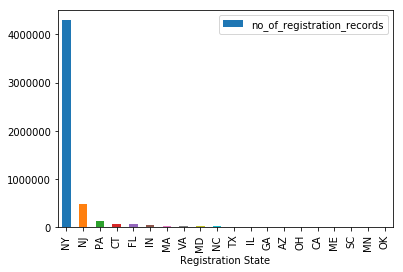

<Figure size 3600x2880 with 0 Axes>

In [32]:
#Let us plot the above data graphically
import pandas as pd
import matplotlib.pyplot as plt

registration_state_graph = registration_state.toPandas()
registration_state_graph.head(20).plot(x='Registration State', y='no_of_registration_records', kind='bar')
plt.figure(figsize=(50,40))
plt.show()

## Aggregation tasks

### 1.Frequency of  violation codes

In [34]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Violation Code")).show()

+------------------------------+
|count(DISTINCT Violation Code)|
+------------------------------+
|                           100|
+------------------------------+



In [36]:
#Frequency of top 5 violation code
freq_violation_code = spark.sql("select distinct(`Violation Code`), count(`Violation Code`) as number_of_records from nycparktable_2017 group by `Violation Code` order by number_of_records desc")
freq_violation_code.show(5)

+--------------+-----------------+
|Violation Code|number_of_records|
+--------------+-----------------+
|            21|           768087|
|            36|           662765|
|            38|           542079|
|            14|           476664|
|            20|           319646|
+--------------+-----------------+
only showing top 5 rows



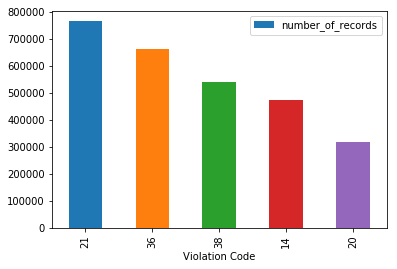

<Figure size 3600x2880 with 0 Axes>

In [38]:
#Let us plot the above values in a graph
freq_violation_code_graph = freq_violation_code.toPandas()
freq_violation_code_graph.head(5).plot(x='Violation Code', y='number_of_records', kind='bar')
plt.figure(figsize=(50,40))
plt.show()

### 2.a. Frequency of a vehicle body type getting a ticket

In [39]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Vehicle Body Type")).show()

+---------------------------------+
|count(DISTINCT Vehicle Body Type)|
+---------------------------------+
|                             1165|
+---------------------------------+



In [41]:
#Frequency of top 5 vehicle body getting a ticket
freq_vehicle_body = spark.sql("select distinct(`Vehicle Body Type`), count(`Vehicle Body Type`) as number_of_records from nycparktable_2017 group by `Vehicle Body Type` order by number_of_records desc")
freq_vehicle_body.show(5)

+-----------------+-----------------+
|Vehicle Body Type|number_of_records|
+-----------------+-----------------+
|             SUBN|          1883954|
|             4DSD|          1547312|
|              VAN|           724029|
|             DELV|           358984|
|              SDN|           194197|
+-----------------+-----------------+
only showing top 5 rows



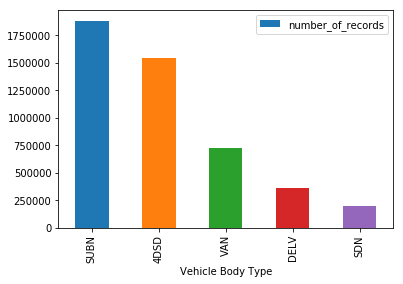

<Figure size 3600x2880 with 0 Axes>

In [43]:
#Let us plot the above values in a graph
freq_vehicle_body_graph = freq_vehicle_body.toPandas()
freq_vehicle_body_graph.head(5).plot(x='Vehicle Body Type', y='number_of_records', kind='bar')
plt.figure(figsize=(50,40))
plt.show()

### 2.b. Frequency of a vehicle make getting a ticket

In [46]:
from pyspark.sql.functions import countDistinct
nyc_park.select(countDistinct("Vehicle Make")).show()

+----------------------------+
|count(DISTINCT Vehicle Make)|
+----------------------------+
|                        3179|
+----------------------------+



In [47]:
#Frequency of top 5 vehicle make getting a ticket
freq_vehicle_make = spark.sql("select distinct(`Vehicle Make`), count(`Vehicle Make`) as number_of_records from nycparktable_2017 group by `Vehicle Make` order by number_of_records desc")
freq_vehicle_make.show(5)

+------------+-----------------+
|Vehicle Make|number_of_records|
+------------+-----------------+
|        FORD|           636844|
|       TOYOT|           605291|
|       HONDA|           538884|
|       NISSA|           462017|
|       CHEVR|           356032|
+------------+-----------------+
only showing top 5 rows

